In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm.notebook import tqdm
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from torch.nn import Parameter
import math

import torch
from torch import Tensor
from torch.nn import init
from torch.nn.parameter import Parameter


class LinearDropConnect(nn.Module):
    r"""Applies a linear transformation to the incoming data: :math:`y = xA^T + b`

    This module supports :ref:`TensorFloat32<tf32_on_ampere>`.

    Args:
        in_features: size of each input sample
        out_features: size of each output sample
        bias: If set to ``False``, the layer will not learn an additive bias.
            Default: ``True``

    Shape:
        - Input: :math:`(N, *, H_{in})` where :math:`*` means any number of
          additional dimensions and :math:`H_{in} = \text{in\_features}`
        - Output: :math:`(N, *, H_{out})` where all but the last dimension
          are the same shape as the input and :math:`H_{out} = \text{out\_features}`.

    Attributes:
        weight: the learnable weights of the module of shape
            :math:`(\text{out\_features}, \text{in\_features})`. The values are
            initialized from :math:`\mathcal{U}(-\sqrt{k}, \sqrt{k})`, where
            :math:`k = \frac{1}{\text{in\_features}}`
        bias:   the learnable bias of the module of shape :math:`(\text{out\_features})`.
                If :attr:`bias` is ``True``, the values are initialized from
                :math:`\mathcal{U}(-\sqrt{k}, \sqrt{k})` where
                :math:`k = \frac{1}{\text{in\_features}}`

    Examples::

        >>> m = nn.Linear(20, 30)
        >>> input = torch.randn(128, 20)
        >>> output = m(input)
        >>> print(output.size())
        torch.Size([128, 30])
    """
    __constants__ = ['in_features', 'out_features']
    in_features: int
    out_features: int
    weight: Tensor

    def __init__(self, in_features: int, out_features: int, bias: bool = True, p_dropconnect=0.0) -> None:
        super(LinearDropConnect, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.p_dropconnect = p_dropconnect
        self.weight = Parameter(torch.Tensor(out_features, in_features), requires_grad=True)
        if bias:
            self.bias = Parameter(torch.Tensor(out_features), requires_grad=True)
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self) -> None:
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)

    def forward(self, input: Tensor) -> Tensor:
        return F.linear(input, F.dropout(self.weight, p=self.p_dropconnect, training=self.training), self.bias)

    def extra_repr(self) -> str:
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )

In [ ]:
from torch.nn import Parameter
import math

import torch
from torch import Tensor
from torch.nn import init
from torch.nn.parameter import Parameter

class LinearDropConnect(nn.Module):
    def __init__(self, linear, p_dropconnect=0.0, activate=False):
        super(LinearDropConnect, self).__init__()
        self.linear = linear
        self.p_dropconnect = p_dropconnect
        self.activate = activate

    def forward(self, input: Tensor) -> Tensor:
        return F.linear(input, F.dropout(self.linear.weight, p=self.p_dropconnect, training=self.training or self.activate), self.linear.bias)

In [ ]:
!pip install transformers

     |████████████████████████████████| 1.5MB 5.8MB/s 
     |████████████████████████████████| 2.9MB 31.0MB/s 
     |████████████████████████████████| 890kB 45.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=c8bd36f813cc05c15c15afa0437646f4e71c9b568478aa978df963492a0e6698
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
batch_size_train = 64
batch_size_test = 100
random_seed = 241
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [ ]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.Resize(28),      
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=False,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.Resize(28),
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=False)

Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz to /files/MNIST/raw


Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz to /files/MNIST/raw



Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz to /files/MNIST/raw


Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz to /files/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
import torchvision.models as models

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

class LeNet5_dropconnect(nn.Module):

    def __init__(self, n_classes, p_dropconnect=0.0):
        super(LeNet5_dropconnect, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1),
            nn.BatchNorm2d(128),
        )

        self.classifier = nn.Sequential(
            LinearDropConnect(nn.Linear(in_features=1152, out_features=84), p_dropconnect=p_dropconnect),
            nn.ReLU(),
            LinearDropConnect(nn.Linear(in_features=84, out_features=n_classes), p_dropconnect=p_dropconnect),
        )


    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return probs

class LeNet5_dropout(nn.Module):
    def __init__(self, n_classes, p_dropout=0.5):
        super(LeNet5_dropout, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1),
            nn.BatchNorm2d(128),
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=1152, out_features=84),
            nn.Dropout(p=p_dropout),
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=n_classes),
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return probs

In [ ]:
def train(epoch, model, loader):
    model.train()
    scheduler.step(epoch)

    for batch_idx, (data, target) in enumerate(loader):
      
        optimizer.zero_grad()
        output = model(data.to(device))
        loss = loss_func(output.cpu(), target)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            step = 100. * batch_idx / len(loader)
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(loader.dataset)} ({step:.0f}%)]\tLoss: {loss.item():.6f}")


def test(model, loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in loader:
            output = model(data.to(device))
            test_loss += loss_func(output.cpu(), target).item()
            pred = output.cpu().data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(loader.dataset)
    accuracy = 100. * correct / len(loader.dataset)
    print(f"\nTest set: Avg. loss: {test_loss:.4f}, Accuracy: {correct}/{len(loader.dataset)} ({accuracy:.0f}%)\n")
    return accuracy


def test_MC(model, loader, T=100):
    model.train()
    prediction_all = []
    for i in tqdm(range(1, T+1)):
        test_loss = 0
        correct = 0
        prediction_iter = []
        with torch.no_grad():
            for data, target in loader:
                output = model(data.to(device))
                test_loss += loss_func(output.cpu(), target).item()
                pred = output.cpu().data.max(1, keepdim=True)[1]
                correct += pred.eq(target.data.view_as(pred)).sum()
                prediction_iter.extend(output.cpu().data.tolist())
        prediction_all.append(np.array(prediction_iter))
        test_loss /= len(loader.dataset)
        accuracy = 100. * correct / len(loader.dataset)
        print(f"\nIteration {i}, Test set: Avg. loss: {test_loss:.4f}, Accuracy: {correct}/{len(loader.dataset)} ({accuracy:.0f}%)")
    return np.array(prediction_all)

In [ ]:
log_interval = 200
n_epochs = 50
learning_rate = 1e-4

loss_func = nn.NLLLoss()
model_full = LeNet5_dropconnect(n_classes=10, p_dropconnect=0.0).to(device)
optimizer = optim.Adam(model_full.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.97)

best_accuracy = test(model_full, test_loader)

for epoch in range(1, n_epochs + 1):
    train(epoch, model_full, train_loader)
    accuracy = test(model_full, test_loader)
    if accuracy > best_accuracy: 
       torch.save(model_full.state_dict(), 'best-model-parameters-full.pt')
       best_accuracy = accuracy


Test set: Avg. loss: -0.0010, Accuracy: 827/10000 (8%)

Train Epoch: 1 [0/60000 (0%)]	Loss: -0.106414


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://git

Train Epoch: 1 [12800/60000 (21%)]	Loss: -0.885297
Train Epoch: 1 [25600/60000 (43%)]	Loss: -0.945049
Train Epoch: 1 [38400/60000 (64%)]	Loss: -0.960534
Train Epoch: 1 [51200/60000 (85%)]	Loss: -0.962355

Test set: Avg. loss: -0.0097, Accuracy: 9776/10000 (98%)

Train Epoch: 2 [0/60000 (0%)]	Loss: -0.944889
Train Epoch: 2 [12800/60000 (21%)]	Loss: -0.975081
Train Epoch: 2 [25600/60000 (43%)]	Loss: -0.949610
Train Epoch: 2 [38400/60000 (64%)]	Loss: -0.978177
Train Epoch: 2 [51200/60000 (85%)]	Loss: -0.952233

Test set: Avg. loss: -0.0098, Accuracy: 9839/10000 (98%)

Train Epoch: 3 [0/60000 (0%)]	Loss: -0.991590
Train Epoch: 3 [12800/60000 (21%)]	Loss: -0.988159
Train Epoch: 3 [25600/60000 (43%)]	Loss: -0.980912
Train Epoch: 3 [38400/60000 (64%)]	Loss: -0.973400
Train Epoch: 3 [51200/60000 (85%)]	Loss: -0.978827

Test set: Avg. loss: -0.0098, Accuracy: 9863/10000 (99%)

Train Epoch: 4 [0/60000 (0%)]	Loss: -0.970052
Train Epoch: 4 [12800/60000 (21%)]	Loss: -0.952685
Train Epoch: 4 [25600/

In [ ]:
print(f'best accuracy during training {best_accuracy}')

best accuracy during training 99.1500015258789


In [ ]:
model_full = LeNet5_dropconnect(n_classes=10, p_dropconnect=0.0).to(device)
model_full.load_state_dict(torch.load('best-model-parameters-full.pt'))

<All keys matched successfully>

In [ ]:
preds = test_MC(model_full, test_loader, T=1)
y_true = test_loader.dataset.targets.numpy()
y_pred = np.argmax(np.mean(preds, axis=0), axis=1)
print(f'best accuracy MC {(y_true==y_pred).sum() / len(y_pred)}')


Iteration 1, Test set: Avg. loss: -0.0099, Accuracy: 9914/10000 (99%)

best accuracy MC 0.9914


(array([ 0.90298334,  1.35447501,  1.80596668,  0.90298334,  1.35447501,
         0.45149167,  0.45149167,  1.35447501,  0.90298334,  0.45149167,
         1.35447501,  0.90298334,  1.35447501,  0.90298334,  0.90298334,
         1.80596668,  1.80596668,  2.25745835,  1.80596668, 15.80220845]),
 array([0.48491144, 0.51066586, 0.53642029, 0.56217471, 0.58792913,
        0.61368355, 0.63943797, 0.6651924 , 0.69094682, 0.71670124,
        0.74245566, 0.76821008, 0.79396451, 0.81971893, 0.84547335,
        0.87122777, 0.89698219, 0.92273661, 0.94849104, 0.97424546,
        0.99999988]),
 <a list of 20 Patch objects>)

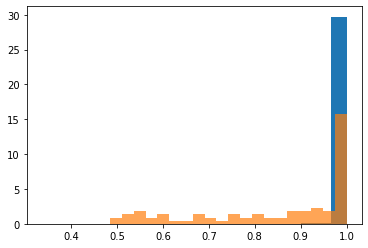

In [ ]:
import matplotlib.pyplot as plt

y_pred_prob = np.max(np.mean(preds, axis=0), axis=1)
plt.hist(y_pred_prob[y_true==y_pred], bins=20, density=True)
plt.hist(y_pred_prob[y_true!=y_pred], bins=20, density=True, alpha=0.7)

In [ ]:
%%time

loss_func = nn.NLLLoss()
model_dc = LeNet5_dropconnect(n_classes=10, p_dropconnect=0.5).to(device)
optimizer = optim.Adam(model_dc.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.97)

best_accuracy = test(model_dc, test_loader)

for epoch in range(1, n_epochs + 1):
    train(epoch, model_dc, train_loader)
    accuracy = test(model_dc, test_loader)
    if accuracy > best_accuracy: 
       torch.save(model_dc.state_dict(), 'best-model-parameters-dc.pt')
       best_accuracy = accuracy


Test set: Avg. loss: -0.0010, Accuracy: 844/10000 (8%)

Train Epoch: 1 [0/60000 (0%)]	Loss: -0.084705


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://git

Train Epoch: 1 [12800/60000 (21%)]	Loss: -0.772127
Train Epoch: 1 [25600/60000 (43%)]	Loss: -0.883681
Train Epoch: 1 [38400/60000 (64%)]	Loss: -0.832942
Train Epoch: 1 [51200/60000 (85%)]	Loss: -0.946287

Test set: Avg. loss: -0.0095, Accuracy: 9674/10000 (97%)

Train Epoch: 2 [0/60000 (0%)]	Loss: -0.874082
Train Epoch: 2 [12800/60000 (21%)]	Loss: -0.951472
Train Epoch: 2 [25600/60000 (43%)]	Loss: -0.940197
Train Epoch: 2 [38400/60000 (64%)]	Loss: -0.941445
Train Epoch: 2 [51200/60000 (85%)]	Loss: -0.934088

Test set: Avg. loss: -0.0097, Accuracy: 9754/10000 (98%)

Train Epoch: 3 [0/60000 (0%)]	Loss: -0.971806
Train Epoch: 3 [12800/60000 (21%)]	Loss: -0.956440
Train Epoch: 3 [25600/60000 (43%)]	Loss: -0.943777
Train Epoch: 3 [38400/60000 (64%)]	Loss: -0.988946
Train Epoch: 3 [51200/60000 (85%)]	Loss: -0.988142

Test set: Avg. loss: -0.0098, Accuracy: 9789/10000 (98%)

Train Epoch: 4 [0/60000 (0%)]	Loss: -0.977100
Train Epoch: 4 [12800/60000 (21%)]	Loss: -0.974912
Train Epoch: 4 [25600/

In [ ]:
print(f'best accuracy during training {best_accuracy}')

best accuracy during training 99.1500015258789


In [ ]:
model_dc = LeNet5_dropconnect(n_classes=10, p_dropconnect=0.5).to(device)
model_dc.load_state_dict(torch.load('best-model-parameters-dc.pt'))

<All keys matched successfully>


Iteration 1, Test set: Avg. loss: -0.0099, Accuracy: 9864/10000 (99%)

Iteration 2, Test set: Avg. loss: -0.0099, Accuracy: 9862/10000 (99%)

Iteration 3, Test set: Avg. loss: -0.0099, Accuracy: 9873/10000 (99%)

Iteration 4, Test set: Avg. loss: -0.0099, Accuracy: 9877/10000 (99%)

Iteration 5, Test set: Avg. loss: -0.0099, Accuracy: 9869/10000 (99%)

Iteration 6, Test set: Avg. loss: -0.0099, Accuracy: 9875/10000 (99%)

Iteration 7, Test set: Avg. loss: -0.0099, Accuracy: 9877/10000 (99%)

Iteration 8, Test set: Avg. loss: -0.0099, Accuracy: 9861/10000 (99%)

Iteration 9, Test set: Avg. loss: -0.0099, Accuracy: 9870/10000 (99%)

Iteration 10, Test set: Avg. loss: -0.0099, Accuracy: 9877/10000 (99%)

Iteration 11, Test set: Avg. loss: -0.0099, Accuracy: 9872/10000 (99%)

Iteration 12, Test set: Avg. loss: -0.0099, Accuracy: 9882/10000 (99%)

Iteration 13, Test set: Avg. loss: -0.0099, Accuracy: 9876/10000 (99%)

Iteration 14, Test set: Avg. loss: -0.0098, Accuracy: 9859/10000 (99%)



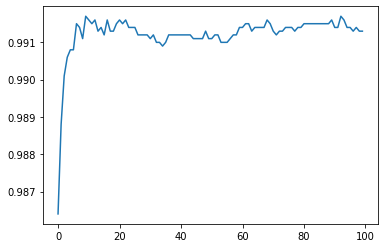

In [ ]:
preds = test_MC(model_dc, test_loader, T=100)
y_true = test_loader.dataset.targets.numpy()
y_pred = np.argmax(np.mean(preds, axis=0), axis=1)

accuracy_mc = []
for n in range(1, len(preds)+1):
    y_pred = np.argmax(np.mean(preds[:n], axis=0), axis=1)
    accuracy_mc.append((y_true==y_pred).sum() / len(y_pred))

import matplotlib.pyplot as plt

plt.plot(accuracy_mc)
print(f'best accuracy MC {np.max(accuracy_mc)}')

(array([0.66943275, 0.33471638, 0.33471638, 0.33471638, 1.00414913,
        2.00829826, 2.34301464, 1.67358188, 2.00829826, 2.67773101,
        1.67358188, 1.00414913, 0.33471638, 1.67358188, 0.66943275,
        1.00414913, 3.01244739, 0.66943275, 3.01244739, 2.67773101]),
 array([0.31307098, 0.34741126, 0.38175153, 0.41609181, 0.45043209,
        0.48477236, 0.51911264, 0.55345291, 0.58779319, 0.62213347,
        0.65647374, 0.69081402, 0.7251543 , 0.75949457, 0.79383485,
        0.82817513, 0.8625154 , 0.89685568, 0.93119595, 0.96553623,
        0.99987651]),
 <a list of 20 Patch objects>)

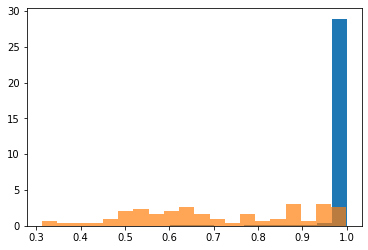

In [ ]:
y_pred_prob = np.max(np.mean(preds, axis=0), axis=1)
plt.hist(y_pred_prob[y_true==y_pred], bins=20, density=True)
plt.hist(y_pred_prob[y_true!=y_pred], bins=20, density=True, alpha=0.7)

In [ ]:
%%time

loss_func = nn.NLLLoss()
model_do = LeNet5_dropout(n_classes=10, p_dropout=0.5).to(device)
optimizer = optim.Adam(model_do.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.97)

best_accuracy = test(model_do, test_loader)

for epoch in range(1, n_epochs + 1):
    train(epoch, model_do, train_loader)
    accuracy = test(model_do, test_loader)
    if accuracy > best_accuracy: 
       torch.save(model_do.state_dict(), 'best-model-parameters-do.pt')
       best_accuracy = accuracy


Test set: Avg. loss: -0.0010, Accuracy: 505/10000 (5%)

Train Epoch: 1 [0/60000 (0%)]	Loss: -0.098948


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://git

Train Epoch: 1 [12800/60000 (21%)]	Loss: -0.786070
Train Epoch: 1 [25600/60000 (43%)]	Loss: -0.923782
Train Epoch: 1 [38400/60000 (64%)]	Loss: -0.893674
Train Epoch: 1 [51200/60000 (85%)]	Loss: -0.946655

Test set: Avg. loss: -0.0097, Accuracy: 9743/10000 (97%)

Train Epoch: 2 [0/60000 (0%)]	Loss: -0.921194
Train Epoch: 2 [12800/60000 (21%)]	Loss: -0.960259
Train Epoch: 2 [25600/60000 (43%)]	Loss: -0.966194
Train Epoch: 2 [38400/60000 (64%)]	Loss: -0.932849
Train Epoch: 2 [51200/60000 (85%)]	Loss: -0.964749

Test set: Avg. loss: -0.0098, Accuracy: 9816/10000 (98%)

Train Epoch: 3 [0/60000 (0%)]	Loss: -0.992305
Train Epoch: 3 [12800/60000 (21%)]	Loss: -0.940369
Train Epoch: 3 [25600/60000 (43%)]	Loss: -0.954251
Train Epoch: 3 [38400/60000 (64%)]	Loss: -0.948719
Train Epoch: 3 [51200/60000 (85%)]	Loss: -0.971163

Test set: Avg. loss: -0.0098, Accuracy: 9845/10000 (98%)

Train Epoch: 4 [0/60000 (0%)]	Loss: -0.964617
Train Epoch: 4 [12800/60000 (21%)]	Loss: -0.960706
Train Epoch: 4 [25600/

In [ ]:
print(f'best accuracy during training {best_accuracy}')

best accuracy during training 99.01000213623047


In [ ]:
model_do = LeNet5_dropout(n_classes=10, p_dropout=0.5).to(device)
model_do.load_state_dict(torch.load('best-model-parameters-do.pt'))

<All keys matched successfully>


Iteration 1, Test set: Avg. loss: -0.0099, Accuracy: 9872/10000 (99%)

Iteration 2, Test set: Avg. loss: -0.0098, Accuracy: 9856/10000 (99%)

Iteration 3, Test set: Avg. loss: -0.0099, Accuracy: 9861/10000 (99%)

Iteration 4, Test set: Avg. loss: -0.0099, Accuracy: 9874/10000 (99%)

Iteration 5, Test set: Avg. loss: -0.0099, Accuracy: 9860/10000 (99%)

Iteration 6, Test set: Avg. loss: -0.0099, Accuracy: 9877/10000 (99%)

Iteration 7, Test set: Avg. loss: -0.0099, Accuracy: 9864/10000 (99%)

Iteration 8, Test set: Avg. loss: -0.0098, Accuracy: 9862/10000 (99%)

Iteration 9, Test set: Avg. loss: -0.0099, Accuracy: 9871/10000 (99%)

Iteration 10, Test set: Avg. loss: -0.0098, Accuracy: 9853/10000 (99%)

Iteration 11, Test set: Avg. loss: -0.0098, Accuracy: 9854/10000 (99%)

Iteration 12, Test set: Avg. loss: -0.0099, Accuracy: 9876/10000 (99%)

Iteration 13, Test set: Avg. loss: -0.0099, Accuracy: 9863/10000 (99%)

Iteration 14, Test set: Avg. loss: -0.0098, Accuracy: 9851/10000 (99%)



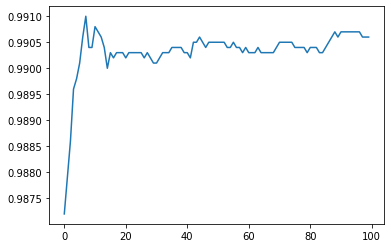

In [ ]:
preds = test_MC(model_do, test_loader, T=100)
y_true = test_loader.dataset.targets.numpy()
y_pred = np.argmax(np.mean(preds, axis=0), axis=1)

accuracy_mc = []
for n in range(1, len(preds)+1):
    y_pred = np.argmax(np.mean(preds[:n], axis=0), axis=1)
    accuracy_mc.append((y_true==y_pred).sum() / len(y_pred))

import matplotlib.pyplot as plt

plt.plot(accuracy_mc)
print(f'best accuracy MC {np.max(accuracy_mc)}')

(array([0.69138508, 0.34569254, 2.07415524, 2.76554033, 1.7284627 ,
        1.7284627 , 1.03707762, 0.69138508, 0.69138508, 1.38277016,
        2.76554033, 0.34569254, 1.38277016, 1.03707762, 2.41984778,
        0.34569254, 1.7284627 , 1.03707762, 3.80261795, 4.49400303]),
 array([0.38429912, 0.41507299, 0.44584686, 0.47662073, 0.5073946 ,
        0.53816847, 0.56894235, 0.59971622, 0.63049009, 0.66126396,
        0.69203783, 0.7228117 , 0.75358558, 0.78435945, 0.81513332,
        0.84590719, 0.87668106, 0.90745493, 0.93822881, 0.96900268,
        0.99977655]),
 <a list of 20 Patch objects>)

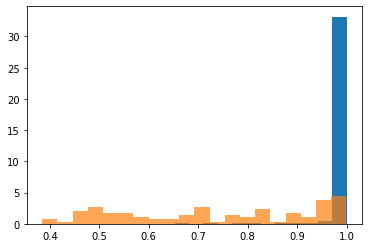

In [ ]:
y_pred_prob = np.max(np.mean(preds, axis=0), axis=1)
plt.hist(y_pred_prob[y_true==y_pred], bins=20, density=True)
plt.hist(y_pred_prob[y_true!=y_pred], bins=20, density=True, alpha=0.7)